In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_data
import preprocessing
import feature_extraction
import dimension_reduction
import classification
import matplotlib
import os

test_size = 0.2
random_state = 104

[nltk_data] Downloading package wordnet to /home/makus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/makus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

os.chdir('/home/makus/Documents/Semester_7_WIN2022/Bachelorarbeit/bachelor-thesis/img/')

# load data

In [3]:
lingspam = import_data.create_df_from_csv('/home/makus/Documents/Semester_7_WIN2022/Bachelorarbeit/ba_code/datasets/messages.csv')
lingspam

,text,label
0,job posting - apple-iss research centercontent...,0
1,"Subjectlang classification grimes , joseph e ....",0
2,query : letter frequencies for text identifica...,0
3,riska colleague and i are researching the diff...,0
4,request book informationearlier this morning i...,0
...,...,...
2888,love your profile - ysuolvpvhello thanks for s...,1
2889,you have been asked to join kiddinthe list own...,1
2890,anglicization of composers ' namesjudging from...,0
2891,"re : 6 . 797 , comparative method : n - ary co...",0


# feature extraction + dimension reduction

In [4]:
y = lingspam['label']
mails = lingspam['text']

tfidf_mails = feature_extraction.tfidf_vectorize(mails)
sparse_mails = dimension_reduction.sparse_random_projection(tfidf_mails)
ipca_mails = dimension_reduction.ipca(sparse_mails, 100)
X = ipca_mails
del mails, tfidf_mails, sparse_mails, ipca_mails, lingspam

X.shape

It took 1.4373121860044193 second(s) to finish TF-IDF feature extraction.
It took 6.4033081460001995 second(s) to finish dimension reduction with Sparse Random Projection.
It took 32.410001904994715 second(s) to finish dimension reduction with IPCA.


(2893, 100)

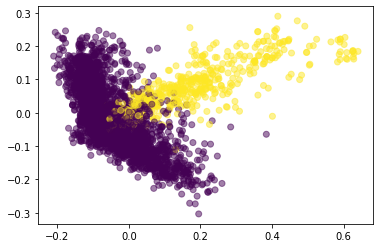

In [5]:
xs = X[:,0]
ys = X[:,1]
colors = y

plt.figure()
plt.scatter(xs, ys, c=colors, alpha=0.5)
plt.savefig('lingspam_graph.pdf')
plt.show()

you can see two elliptical clusters with an intersection in [-0.1:0.1] [-0.1:0.2]. 
Thoughts: Classification in this plane can be hard

# Reference SVM classification

In [6]:
reference_report, X_test, y_test, y_pred = classification.svm(X,y,test_size, random_state)

reference_report

SVM model fitted in 0.525622283006669 second(s)
SVM predicted the testset in 0.08250778699584771 second(s)


,0,1,accuracy,macro avg,weighted avg
precision,0.949416,1.000000,0.955095,0.974708,0.957366
recall,1.000000,0.714286,0.955095,0.857143,0.955095
f1-score,0.974052,0.833333,0.955095,0.903693,0.951936
support,488.000000,91.000000,0.955095,579.000000,579.000000


this is our reference svm for the comparison

Got 26 classificaton mistakes


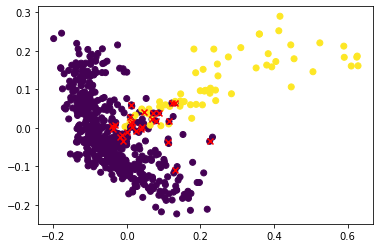

In [7]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig, ax = plt.subplots()
ax.scatter(X_test[:,0], X_test[:,1], c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], color='red', marker="x")
plt.show()

# K-Means with random or kmeans++ init centroids

We want to find out, which centroid initialisation method works better for us

### random:

In [8]:
pd_report, pred_labels, kmeans_labels = classification.search_best_for_n_cluster(2,X,y,random=True)
pd_report

It took 99.18619827999646 second(s) to search the best k-means clustering for merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.943352,0.960114,0.945385,0.951733,0.946139
recall,0.994196,0.700624,0.945385,0.847410,0.945385
f1-score,0.968107,0.810096,0.945385,0.889101,0.941835
support,2412.000000,481.000000,0.945385,2893.000000,2893.000000


### kmeans++:

In [9]:
pd_report, labels, kmeans_labels = classification.search_best_for_n_cluster(2,X,y,random=False)
pd_report

It took 114.07963341799768 second(s) to search the best k-means clustering for merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.942981,0.960000,0.94504,0.951490,0.945810
recall,0.994196,0.698545,0.94504,0.846370,0.945040
f1-score,0.967911,0.808664,0.94504,0.888288,0.941434
support,2412.000000,481.000000,0.94504,2893.000000,2893.000000


seems like random performs better and is massive performance increase.

# K-Means + Elbow plot

Now we create our elbow graph. A cluster count above 25 has not much sense

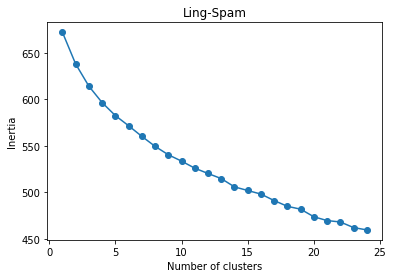

In [11]:
max_cluster = 25
inertias = classification.elbow_inertias_list(X,max_cluster)

plt.figure()
plt.plot(range(1,max_cluster), inertias, marker='o')
plt.title('Ling-Spam')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('lingspam_elbow_high_dim.pdf')
plt.show() 

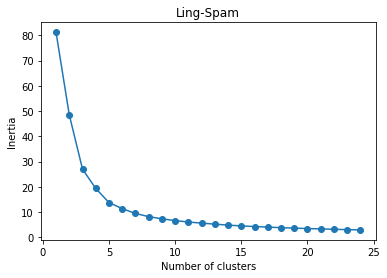

In [12]:
max_cluster = 25
inertias = classification.elbow_inertias_list(X[:,:2],max_cluster)

plt.figure()
plt.plot(range(1,max_cluster), inertias, marker='o')
plt.title('Ling-Spam')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('lingspam_elbow_two_dim.pdf')
plt.show() 

# SVM and K-Means merging hypothesis

Now we test our hypothesis, wether replacing the original labels with k-means generated labels can improve a svm classification

In [13]:
report, X_test, y_test, y_pred = classification.svm_merging_hypothesis(2,X,y)
report

It took 41.650940946004994 second(s) to search the best k-means clustering for merging hypothesis
It took 41.833977362999576 second(s) to complete the svm classification combined with k-means - merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.905380,1.000000,0.911917,0.952690,0.920251
recall,1.000000,0.439560,0.911917,0.719780,0.911917
f1-score,0.950341,0.610687,0.911917,0.780514,0.896958
support,488.000000,91.000000,0.911917,579.000000,579.000000


k-means with the original cluster count does not improve the classification

Got 51 classificaton mistakes


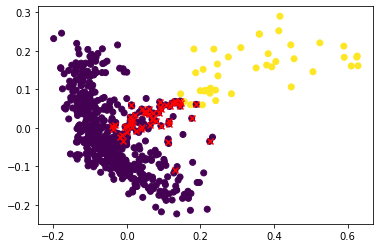

In [14]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig, ax = plt.subplots()
ax.scatter(X_test[:,0], X_test[:,1], c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], color='red', marker="x")
plt.show()

Now we estimate a good cluster count based on the graph

In [15]:
report, X_test, y_test, y_pred = classification.svm_merging_hypothesis(5,X,y)
report

It took 49.57618884699332 second(s) to search the best k-means clustering for merging hypothesis
It took 49.71428771799401 second(s) to complete the svm classification combined with k-means - merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.902033,1.000000,0.908463,0.951017,0.917430
recall,1.000000,0.417582,0.908463,0.708791,0.908463
f1-score,0.948494,0.589147,0.908463,0.768820,0.892016
support,488.000000,91.000000,0.908463,579.000000,579.000000


Got 53 classificaton mistakes


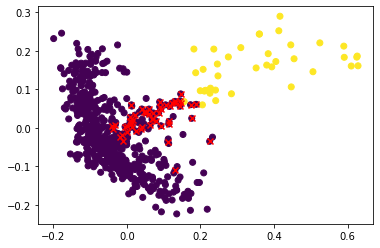

In [16]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig, ax = plt.subplots()
ax.scatter(X_test[:,0], X_test[:,1], c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], color='red', marker="x")
plt.show()

For increasing the number of clusters, the classification is getting worse.
The classification results are worse than the normal SVM

-> Merging is not a good approach

# Adding K-means clustering as new feature

we add now the k-means clustering result as a new column in our dataset and then classify the data with a svm. -> Test this approach with cluster count between 2 and 25

In [17]:
reference_report

,0,1,accuracy,macro avg,weighted avg
precision,0.949416,1.000000,0.955095,0.974708,0.957366
recall,1.000000,0.714286,0.955095,0.857143,0.955095
f1-score,0.974052,0.833333,0.955095,0.903693,0.951936
support,488.000000,91.000000,0.955095,579.000000,579.000000


In [18]:
report = classification.k_means_cluster_search(X,y,25)
report

,Number_of_clusters,Accuracy,F_one_Score,Time
0,2.0,0.934370,0.962376,3.561412
1,3.0,0.932642,0.961500,3.917538
2,4.0,0.908463,0.948393,4.325124
3,5.0,0.794473,0.885246,4.278433
4,6.0,0.842832,0.914714,4.620426
5,7.0,0.880829,0.930373,4.805475
6,8.0,0.816926,0.899240,4.884113
7,9.0,0.816926,0.899240,5.492682
8,10.0,0.842832,0.914714,5.322818
9,11.0,0.842832,0.914714,5.910963


Doesn't seems to be a good aproach too.

# Combine both approaches

Add the merging approach as a new feature vector to the dataset and then classify with svm.

It is very computation heavy even on a small dataset. So even a slightly improve is not worth.

In [23]:
report = classification.k_means_cluster_search_merging_hypothesis(X,y,5)
report

It took 46.557713556001545 second(s) to search the best k-means clustering for merging hypothesis


,Accuracy,F_one_Score,Time
0,0.929188,0.959685,46.661282


In [21]:
report = classification.k_means_cluster_search_merging_hypothesis(X,y,7)
report

It took 62.912851365996175 second(s) to search the best k-means clustering for merging hypothesis


,Accuracy,F_one_Score,Time
0,0.927461,0.958743,63.101152


It is very computation heavy even on a small dataset. So even a slightly improve is not worth.